In [12]:
from google.colab import files # úp file từ máy tính lên colab
uploaded = files.upload()

Saving model .pkl to model .pkl


# Tính uống được của nước

Trong bảng phân tích này em đã khám phá bộ dữ liệu Water Potability từ Kaggle, bộ dữ liệu này gồm 3276 mục dữ liệu và 9 đặc trưng quyết định tính uống được của nước. Một phần giải thích chi tiết về các đặc trưng này có thể được tìm thấy trên trang Kaggle của bộ dữ liệu.

Phân tích bắt đầu với phân tích dữ liệu khám phá (EDA) để hiểu về phân bố dữ liệu, các chỉ số thống kê và chất lượng dữ liệu.Em nhận thấy rằng khoảng 11% dữ liệu là ngoại lai và khoảng 44% dữ liệu bị thiếu giá trị. Để chuẩn bị dữ liệu cho việc mô hình hóa, em đã thực hiện quy trình tiền xử lý nhiều bước gồm:

* Xử lý ngoại lai bằng phương pháp IQR capping để giảm ảnh hưởng của các giá trị cực đoan.

* Bù giá trị thiếu bằng thuật toán k-Láng giềng gần nhất (kNN).

* Để mô hình hóa, tôi đã triển khai hai bộ phân loại học máy:

* Support Vector Machine (SVM): Trước khi bù giá trị thiếu, tôi áp dụng RobustScaler để giảm ảnh hưởng của các giá trị ngoại lai trong quá trình chuẩn hóa.

* Random Forest: Vì các mô hình dựa trên cây ít nhạy cảm hơn với việc chuẩn hóa, tôi không chuẩn hóa dữ liệu cho mô hình này.

** Mục tiêu đồ án **

Dự đoán tính uống được của nước dựa trên các đặc trưng như :
pH, độ cứng, chất rắn, chloramines, sulfate, độ dẫn điện, carbon hữu cơ, trihalomethanes, và độ đục.





# Import các thư viện để Phục vụ cho việc Phân tích

In [13]:
# Mô đun cơ bản
import numpy as np
import pandas as pd

# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Phân tích thống kê
import scipy.stats as stats
from scipy.stats import skew

# Chuẩn hóa dữ liệu & xử lý thiếu
from sklearn.preprocessing import  RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# sử dụng mô hình học máy
from sklearn import svm
from sklearn.svm import SVC

# đánh giá mô hình
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,  recall_score
from sklearn.model_selection import validation_curve


# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# vẽ cây quyết định
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore') # Để ẩn các cảnh báo trong quá trình chạy code,cho notebook gọn gàng.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Download data

In [15]:
df = pd.read_csv('water_potability.csv')  # đọc file dataset upload từ máy tính lên

### a) Thông tin chung và thông tin thống kê

In [16]:
df.head() # COI TRƯỚC 5 DÒNG ĐẦU TIÊN

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [17]:
# In ra thông tin tổng quát về dataframe: số dòng, số cột, kiểu dữ liệu, giá trị thiếu.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


* Bộ dữ liệu chứa 3.276 hàng và 10 cột
* Có những giá trị bị thiếu trong các cột pH, sulfate và trihalomethanes.

### b) Thống kê phân bố nhãn


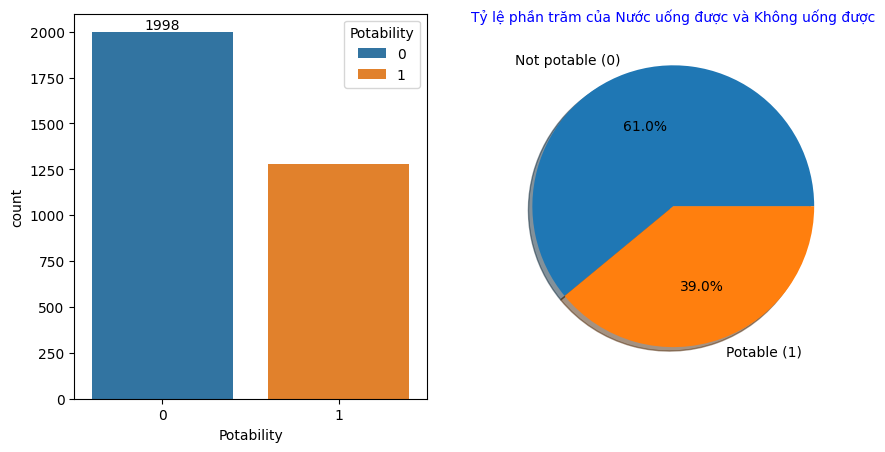

In [18]:
# Counting the number of classes in Rain

fig, ax = plt.subplots(1,2,figsize=(10,5))

# Biểu đồ bar plot (cột)
# Use the original 'Potability' column for the countplot
ax = sns.countplot(data=df, x="Potability",ax=ax[0], hue = "Potability")
ax.bar_label(ax.containers[0])

#pie plot (biểu đồ tròn)
# Sử dụng value_counts() để đếm số liệu cột 'Potibility'
# Gán nhãn cho các giá trị: 0 là 'Không uống được', 1 là 'Uống được'
potability_counts = df['Potability'].value_counts()
potability_labels = {0: 'Not potable (0)', 1: 'Potable (1)'}
# Apply the mapping to the index of the value counts Series
potability_counts.index = potability_counts.index.map(potability_labels)

# Plot the pie chart using the re-indexed value counts
potability_counts.plot.pie(autopct='%1.1f%%', shadow=True, textprops={'fontsize': 10}, ylabel='')

plt.title('Tỷ lệ phần trăm của Nước uống được và Không uống được', fontsize=10 ,color = 'blue')
plt.show() # Hiển thị biểu đồ

### c) Phân bố thông tin

In [19]:
# Phân tích thông tin
# Theo mặc định, Pandas bỏ qua giá trị NaN khi tính toán thống kê mô tả.
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000



* Đối với Chất rắn, sự khác biệt giữa giá trị tối thiểu và tối đa lên tới ba cấp độ so với các cột khác.
  
* Các biến có phạm vi khác nhau; Cụ thể, tính năng chất rắn có phạm vi giá trị lớn hơn đáng kể so với phần còn lại.

* Bằng cách so sánh giá trị trung bình và trung bình (phần trăm thứ 50), chúng tôi quan sát một khoảng cách nhỏ giữa chúng trong cột rắn, cho thấy sự phân phối sai lệch tích cực. Ngược lại, các cột còn lại thể hiện các phân phối giống như Gaussian, vì sự khác biệt giữa phương tiện và trung vị của chúng là tối thiểu.


The following distribution plots support the last three observations.

### d) Visualization

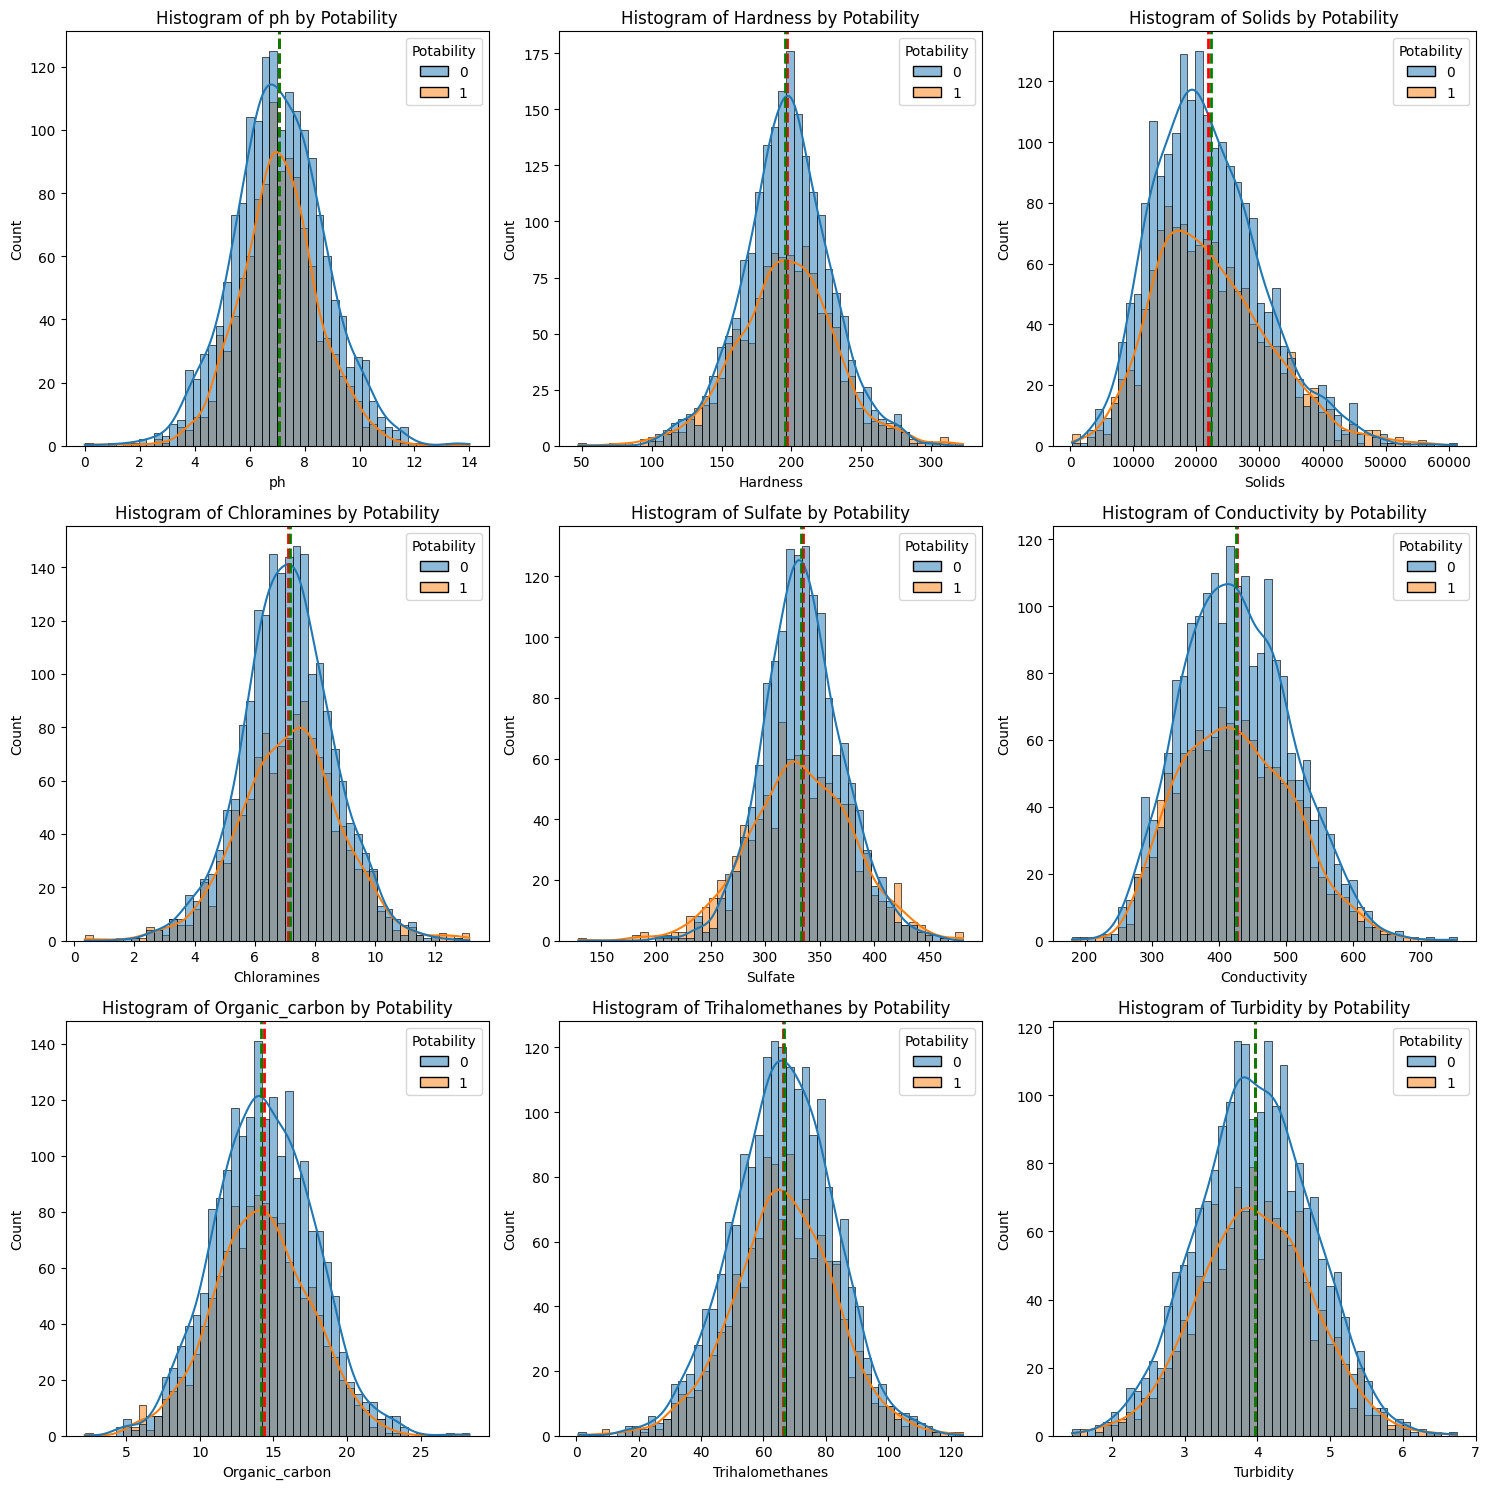

In [20]:
# Histograms with hue for Potability
plt.figure(figsize=(15, 15))

# Change the subplot grid to 3x3 to accommodate 9 plots
for i, col in enumerate(df.columns[:-1]):  # Exclude the last column (Potability)
    plt.subplot(3, 3, i + 1)  # Changed from 3x2 to 3x3
    # Removed legend_out=True as it's not a valid argument for histplot
    sns.histplot(data=df, x=col, hue='Potability', kde=True, bins=50)
    plt.title(f'Histogram of {col} by Potability')

    # Calculate the mean for the current column, grouped by 'Potability'
    mean_col_values = df.groupby('Potability')[col].mean()

    # Add the mean lines for the current column for each 'Potability' category
    # Access the mean value for not potable and potable separately
    plt.axvline(mean_col_values[0], color='red', linestyle='--', linewidth=2, label='Mean (not pot)')
    plt.axvline(mean_col_values[1], color='green', linestyle='--', linewidth=2, label='Mean (pot)') # Using a different color for clarity
    #plt.legend(loc="upper left") # Add legend here to show the mean label on each subplot



plt.tight_layout()
plt.show()

Phân phối cho chất rắn cho thấy độ lệch dương vừa phải, vì đuôi ở phía bên phải dài hơn đuôi bên trái. Độ dẫn điện cũng thể hiện một sai lệch dương. Các cột còn lại chỉ hiển thị độ lệch tối thiểu, đủ nhỏ để phân phối của chúng có thể được coi là xấp xỉ Gaussian.

In [21]:
# compute the skewness
df.groupby(['Potability']).skew(skipna = True)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
Potability,,,,,,,,,
0,0.041441,-0.021491,0.606185,-0.022291,0.118335,0.258431,0.068941,-0.096665,-0.009198
1,-0.018147,-0.046125,0.628156,-0.019584,-0.111839,0.274961,-0.051783,-0.063766,-0.005676


### e) Scatter Plots ( Biểu đồ phân tán )

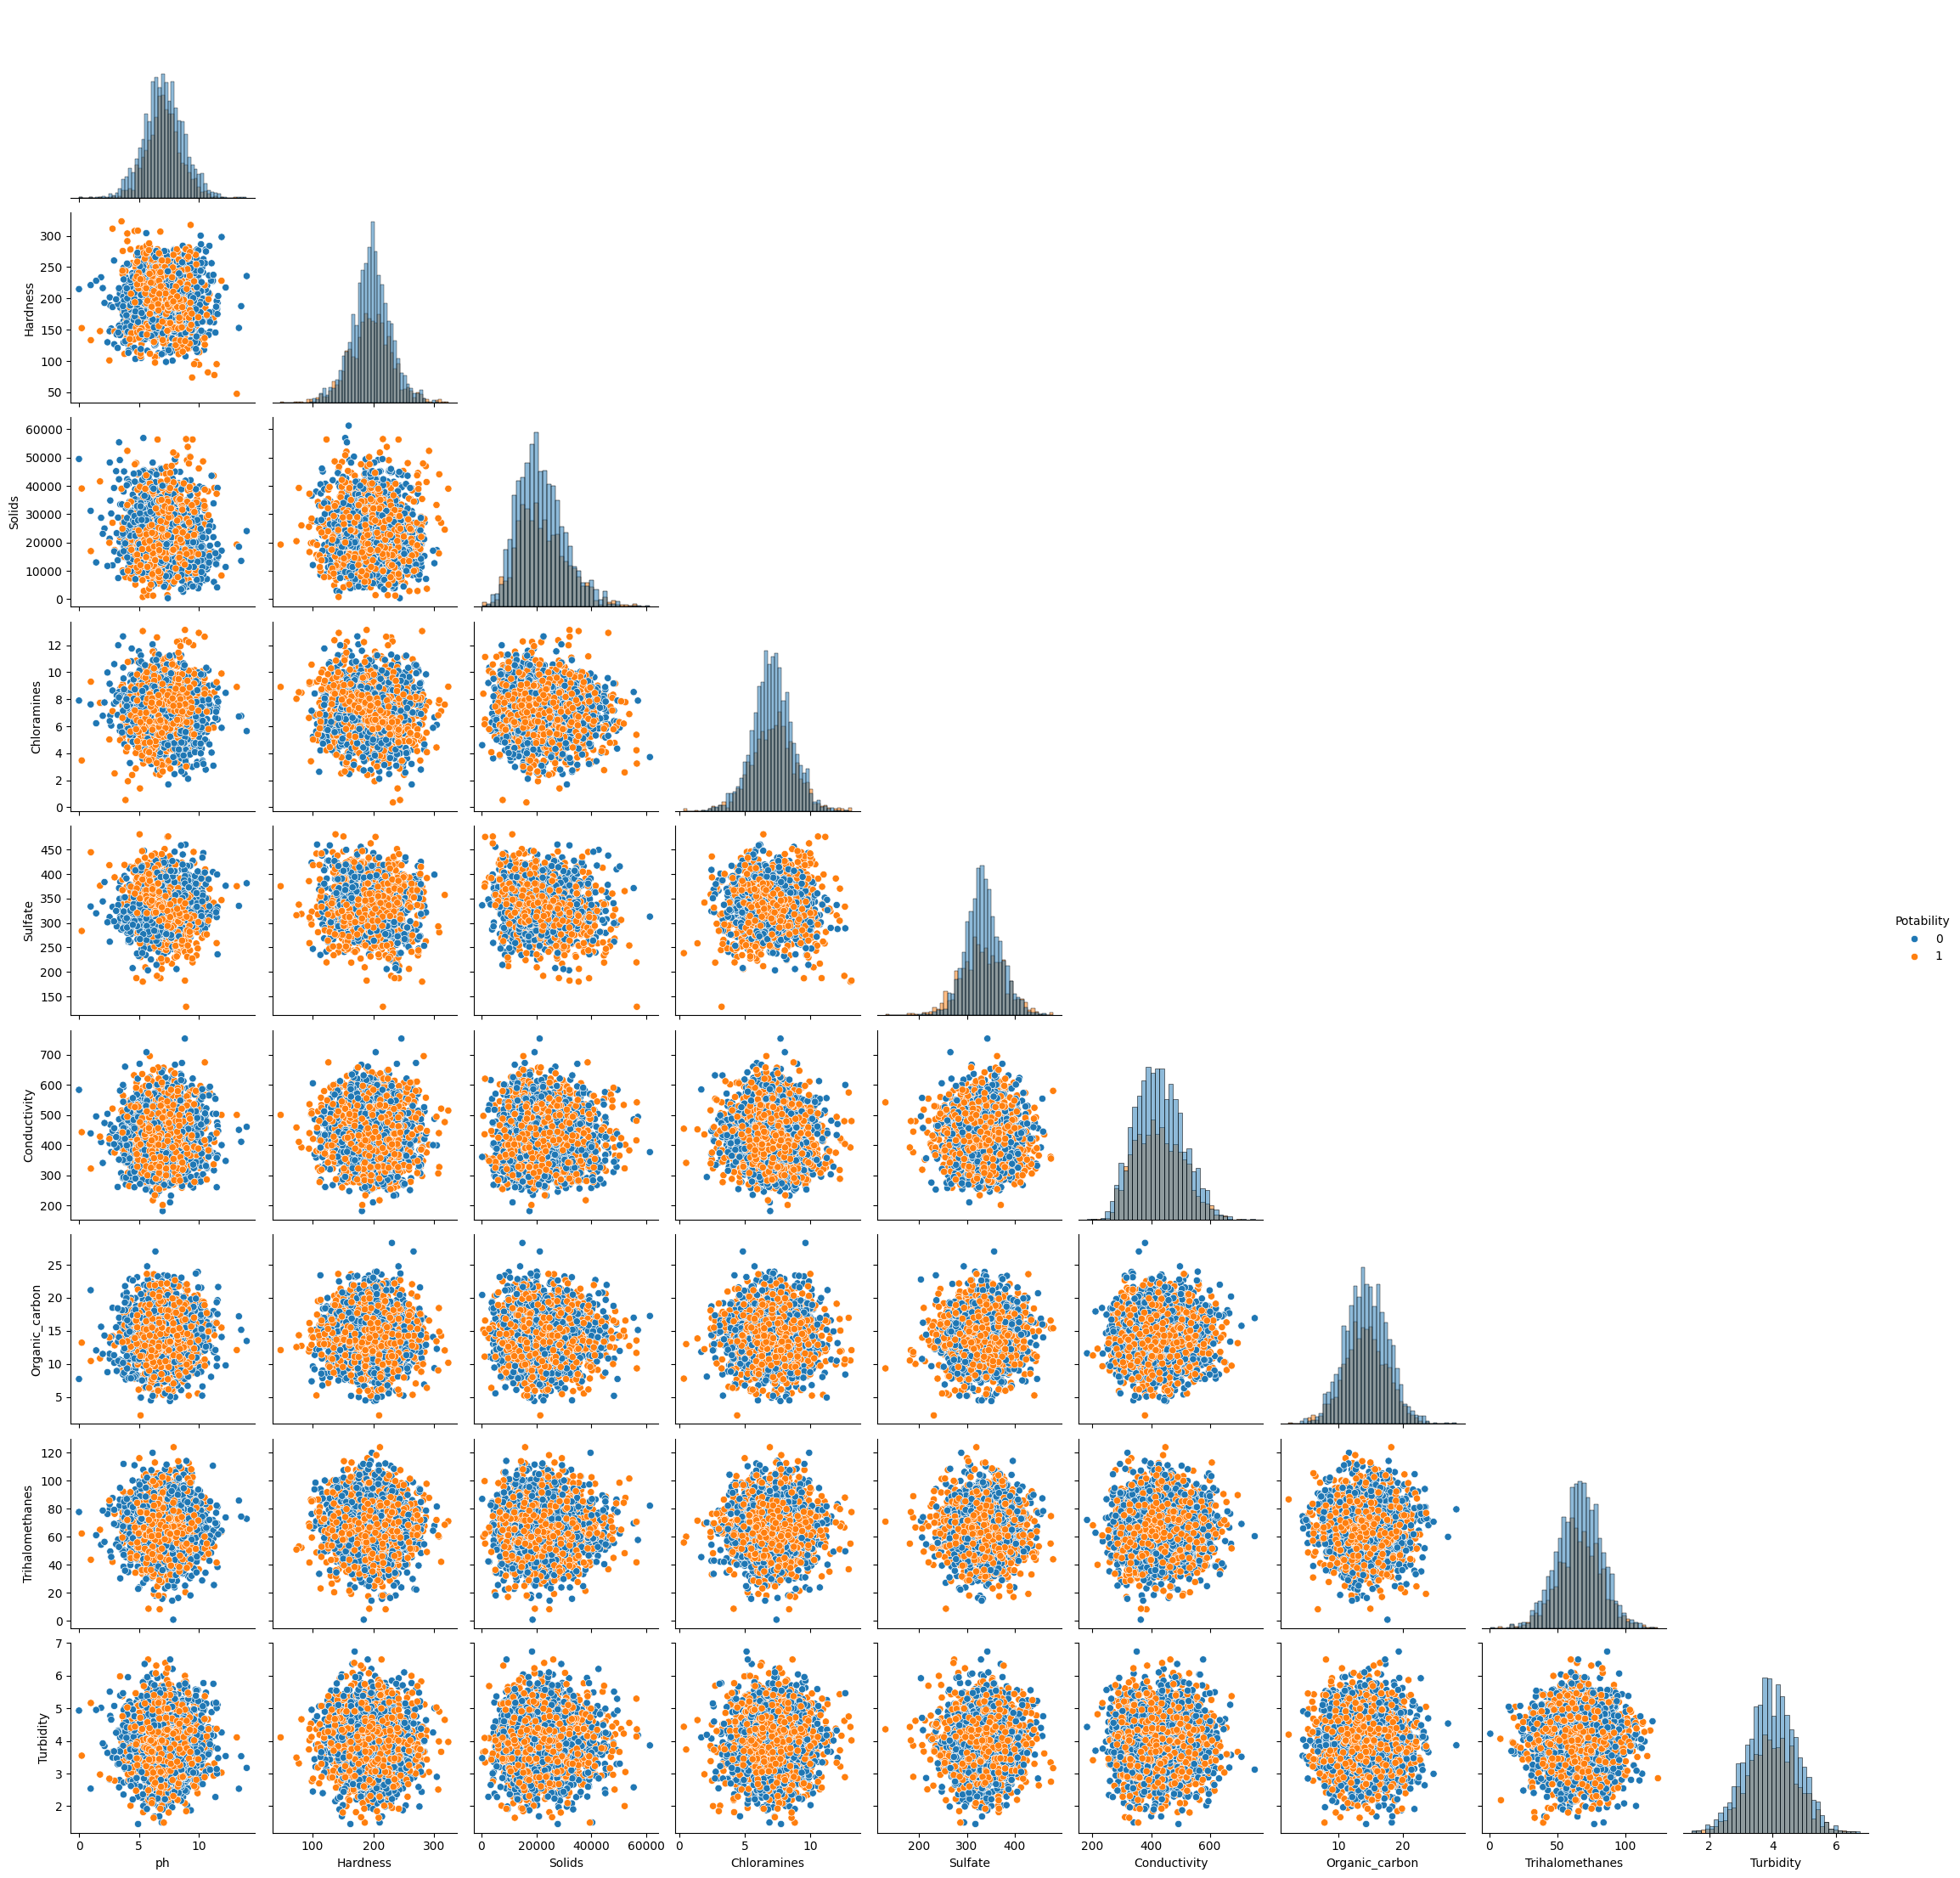

In [22]:
sns.pairplot(df, hue='Potability', corner = True, diag_kind="hist")
plt.show()

### f) Tương quan giữa các cột

Không có mối tương quan giữa một số cột.

In [23]:
# heatmap with mask to avoid nan values
df.corr(method='pearson').style.background_gradient(cmap='coolwarm')

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


### g) Missing Values

In [24]:
# Những cột có giá trị thiếu
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [25]:
# Tỷ lệ phần trăm giá trị bị thiếu
missing_percentage_ph = (df['ph'].isnull().sum() / len(df)) * 100
missing_percentage_sf = (df['Sulfate'].isnull().sum() / len(df)) * 100
missing_percentage_tr = (df['Trihalomethanes'].isnull().sum() / len(df)) * 100
missing_percentage_total = (df.isnull().sum().sum() / len(df)) * 100

print(f"Porcentage of missing values in  'ph':  {missing_percentage_ph:.2f}%")
print(f"Porcentage of missing values in  'Sulfate':  {missing_percentage_sf:.2f}%")
print(f"Porcentaje  of missing values in 'Trihalomethanes':  {missing_percentage_tr:.2f}%")
print(f"Total Porcentaje  of missing values:  {missing_percentage_total:.2f}%")

Porcentage of missing values in  'ph':  14.99%
Porcentage of missing values in  'Sulfate':  23.84%
Porcentaje  of missing values in 'Trihalomethanes':  4.95%
Total Porcentaje  of missing values:  43.77%


Trước khi xử lý các giá trị bị thiếu, chúng ta cần hiểu mô hình xuất hiện của chúng.

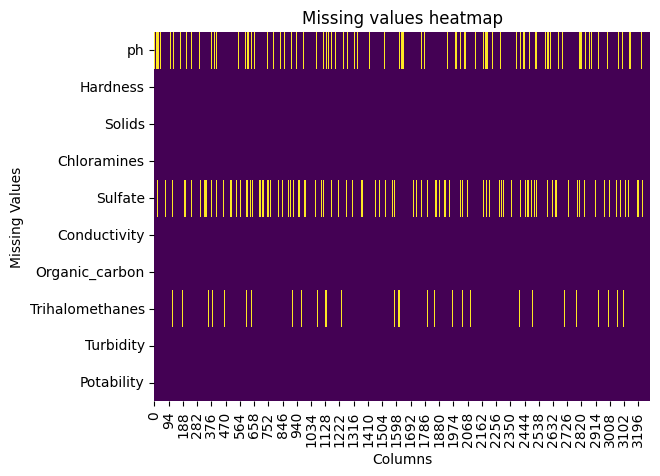

In [26]:
#set figure size
#plt.figure(figsize=(6,6))
ax = plt.axes()
sns.heatmap(df.isna().transpose(),cbar=False, cmap = "viridis",ax = ax)
plt.xlabel("Columns", fontsize = 10)
plt.ylabel("Missing Values", fontsize = 10)
#labels and titles
plt.title("Missing values heatmap")
plt.show()

Các giá trị còn thiếu trong pH xuất hiện trong các khối, trong khi ở sulfate, chúng được phân phối đều hơn trên các hàng. Trong Trihalomethanes, các giá trị bị thiếu được phân tán thưa thớt. Nhìn chung, không có mẫu rõ ràng là rõ ràng trong dữ liệu bị thiếu.

In [27]:
df.isnull().groupby(df['Potability']).sum()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Potability,,,,,,,,,,
0,314,0,0,0,488,0,0,107,0,0
1,177,0,0,0,293,0,0,55,0,0


### h) Outliers

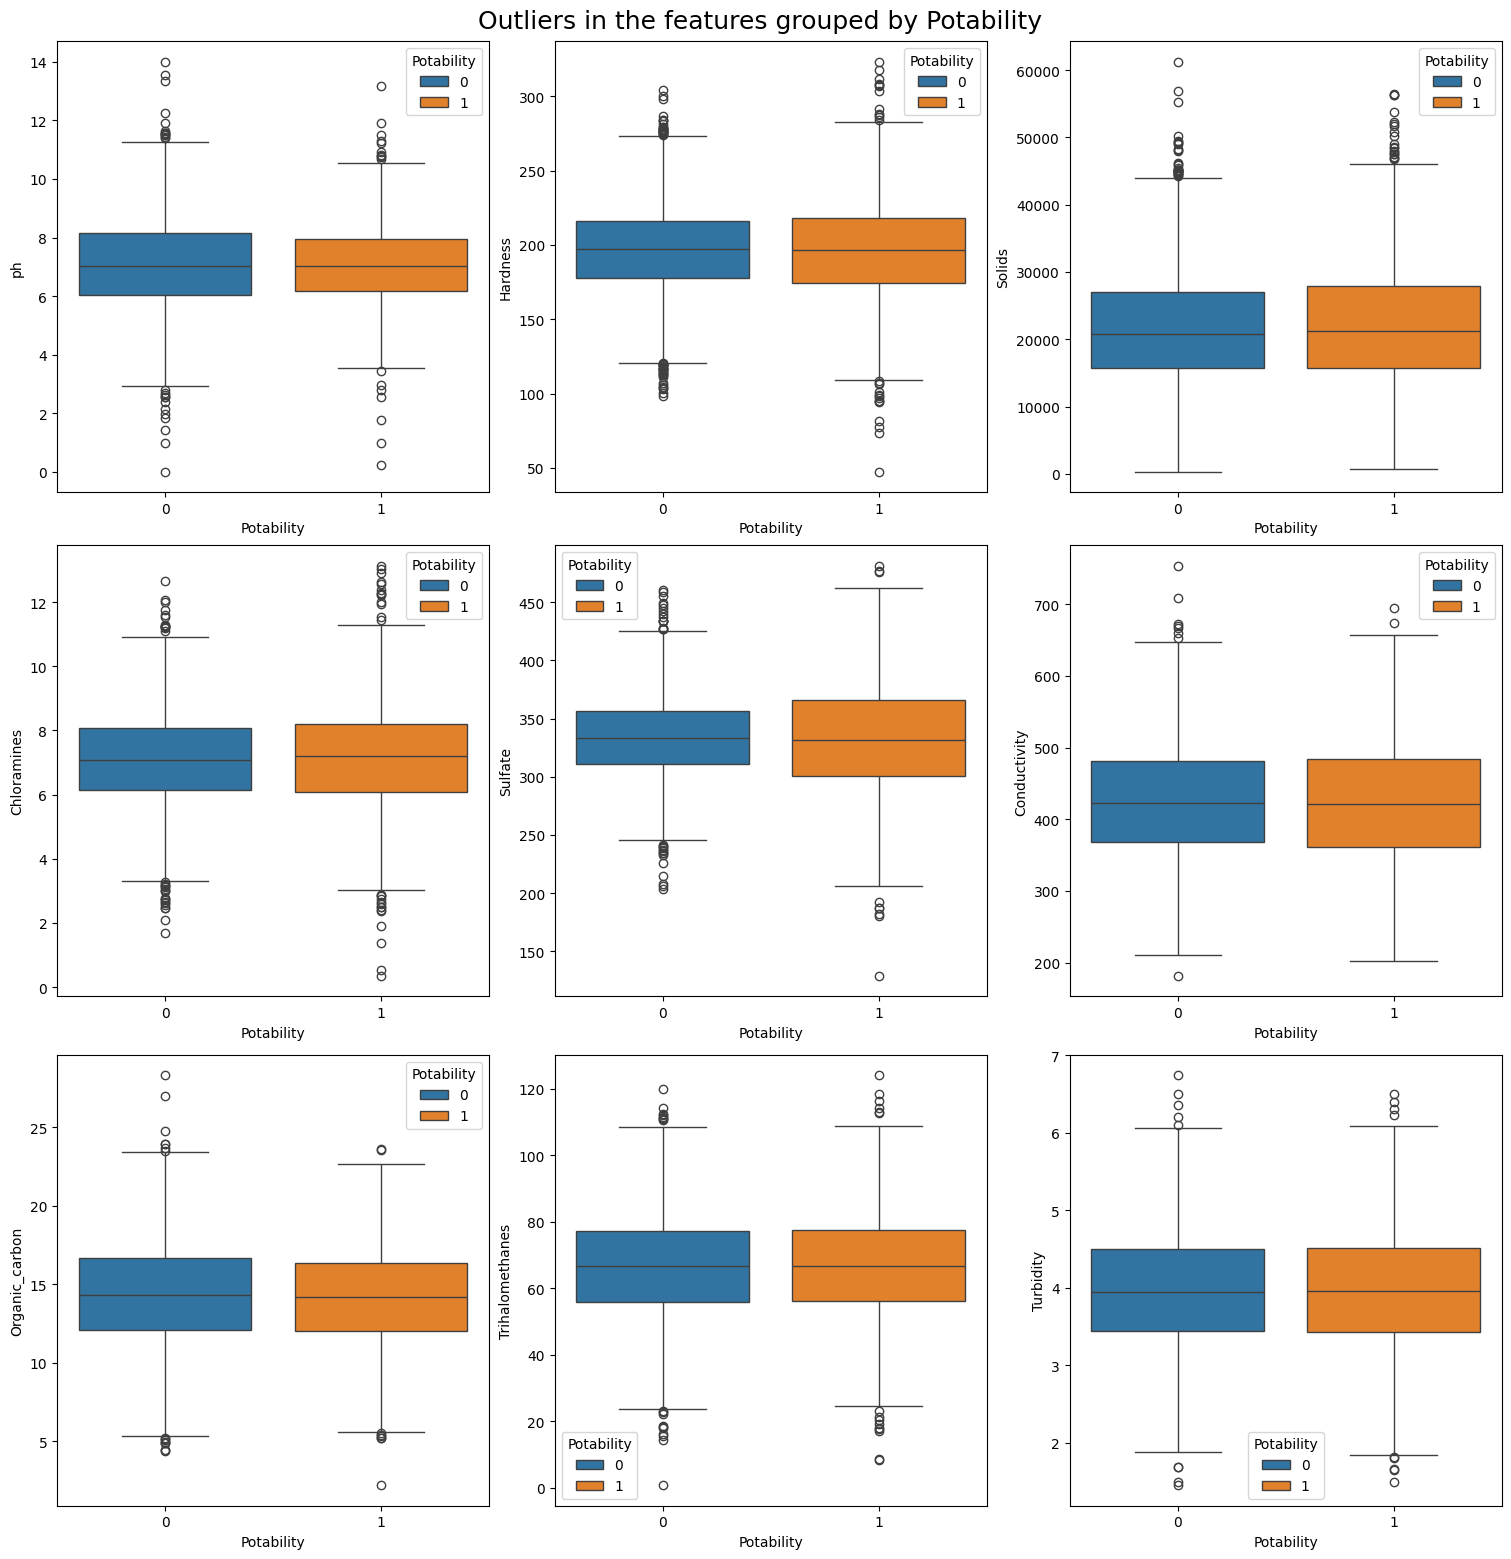

In [28]:
# Change the subplot grid to 4x3 to accommodate 10 plots
fig, axes = plt.subplots(4, 3, constrained_layout=True, figsize=(15, 20)) # Increased figure size for better readability
axes = axes.flatten()

# List of columns to plot (excluding the duplicate 'Conductivity')
columns_to_plot = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]

# Loop through the columns and plot
for i, col in enumerate(columns_to_plot):
    sns.boxplot(x="Potability", y=col, data=df, orient='v',  ax=axes[i], hue = "Potability" )

# Hide any unused subplots (since 10 < 12)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(" Outliers in the features grouped by Potability", fontsize = 18)
plt.show() # Add plt.show() to display the plots

 Độ cứng là các cột có số lượng ngoại lệ nhất

In [29]:
# Count outliers
def outliers(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
  return outliers

In [30]:
outliers_df = outliers(df)
pd.DataFrame({"Count.Outliers": outliers_df.sum(),
            "Pct.Outliers %": (outliers_df.sum() * 100/ len(df)).round(2)})

,Count.Outliers,Pct.Outliers %
ph,46,1.40
Hardness,83,2.53
Solids,47,1.43
Chloramines,61,1.86
Sulfate,41,1.25
Conductivity,11,0.34
Organic_carbon,25,0.76
Trihalomethanes,33,1.01
Turbidity,19,0.58
Potability,0,0.00


In [31]:
print(f" Tổng phần trăm của ngoại lệ: {((outliers_df.sum().sum()/ len(df)) * 100):.2f} %")

 Tổng phần trăm của ngoại lệ: 11.17 %


Bộ dữ liệu này có 43,8 % giá trị bị thiếu và 11,17 % các ngoại lệ.

Bởi vì số lượng ngoại lệ nhỏ hơn số lượng các giá trị bị thiếu, trước tiên tôi đối phó với các ngoại lệ.

## 3) Tiền xử lý

### a) Giới hạn các ngoại lệ với phạm vi liên vùng (IQR)

In [32]:
# apply cap with IQR
def cap_outliers_iqr(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = ((df < lower_bound) | (df > upper_bound))
  return np.clip(df, lower_bound, upper_bound)

df_cap_iqr = df.groupby('Potability').transform(cap_outliers_iqr)

### b) Dữ liệu riêng biệt thành các tính năng và mục tiêu

In [33]:
# separate data
X= df_cap_iqr
y=df["Potability"]

### c) Tách dữ liệu và áp dụng robust scaler


Em chọn các K-Newest Neighbors (KNN) để đưa ra các giá trị bị thiếu. Để làm điều này, trước tiên em đã chia tỷ lệ dữ liệu, vì KNN nhạy cảm với quy mô của các tính năng. Biến mục tiêu trong phân tích này là khả năng. Tôi đã sử dụng máy nhân mạnh mẽ vì nó quy mô các tính năng sử dụng các số liệu thống kê mạnh mẽ cho các ngoại lệ.

In [34]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler with Robust Scaler
scaler = RobustScaler( with_scaling=True, with_centering = True, quantile_range=(25.0, 75.0))

# scaler fit and transform
X_train_scaled = scaler.fit_transform(X_train, y=None)
X_test_scaled = scaler.fit_transform(X_test, y=None)

### d) K-Nearest Neighbor (KNN) Cắt bỏ các giá trị bị thiếu

In [35]:
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=10, weights="uniform") # default values for weights = uniform and metric = nan_euclidean

# Apply KNN imputation, fit and transform
X_train_trf = imputer.fit_transform(X_train_scaled)
X_test_trf = imputer.transform(X_test_scaled)

# Verify that missing values are gone
print("\nMissing values after KNN imputation:")
print(sum(np.isnan(X_train_trf)))



Missing values after KNN imputation:
[0 0 0 0 0 0 0 0 0]


In [36]:
print(sum(np.isnan(X_test_trf)))

[0 0 0 0 0 0 0 0 0]


## 4) Support Vector Machin (SVM)

### a) Linear kernel

In [37]:
# Create the model: linear model
linear_model = SVC(kernel='linear',C=0.5)

# Train the model with the training data
linear_model_train = linear_model.fit(X_train_trf, y_train)

# Predict with the test data
y_pred_linear = linear_model_train.predict(X_test_trf)

In [38]:
# Calculating the accuracy of the linear model
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy: {accuracy_linear:.2f}")

# Displaying confusion matrix and classification report for the linear model
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
class_report_linear = classification_report(y_test, y_pred_linear)

print("\nConfusion Matrix (Linear SVM):")
print(conf_matrix_linear)
print("\nClassification Report (Linear SVM):")
print(class_report_linear)

Linear SVM Accuracy: 0.63

Confusion Matrix (Linear SVM):
[[412   0]
 [244   0]]

Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



SVM tuyến tính rõ ràng là không hiệu quả, vì nó không xác định được bất kỳ tích cực thực sự nào.

## b) Radial Basic Function (RBF) kernel

In [39]:
# Create a RBF model classifiers
rbf_model = SVC(kernel='rbf', C=0.1,class_weight='balanced', gamma = 0.1)

# Train the model with the training data
rbf_model_train = rbf_model.fit(X_train_trf, y_train)

# Predict with the test  and train
y_test_pred_rbf = rbf_model_train.predict(X_test_trf)
y_train_pred_rbf = rbf_model_train.predict(X_train_trf)

In [40]:
# Đánh giá phân loại

svm_classification = classification_report(y_test, y_test_pred_rbf)
print(svm_classification)

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       412
           1       0.54      0.34      0.42       244

    accuracy                           0.65       656
   macro avg       0.61      0.58      0.58       656
weighted avg       0.63      0.65      0.62       656



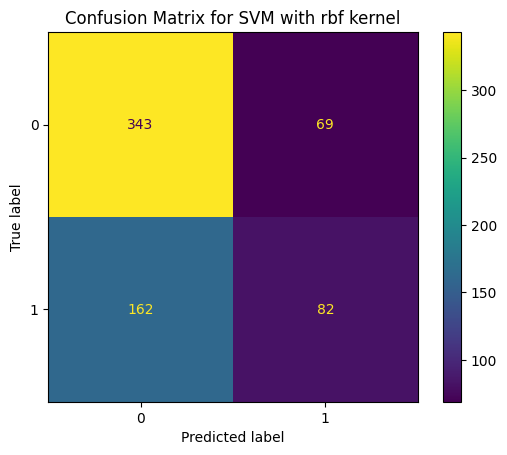

In [41]:
# Tính toán ma trận nhầm lẫn
cm_svm = confusion_matrix(y_test, y_test_pred_rbf)

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for SVM with rbf kernel")
plt.show()

Mô hình này hoạt động tốt hơn tuyến tính. Số lượng dương tính thực sự là 82 và các tiêu cực sai 69. Dưới đây tôi hiển thị các đường cong xác nhận giúp tôi chọn các giá trị tốt nhất của các siêu âm.


#### Điều chỉnh các siêu âm

Best C value based on testing accuracy: 0.1
Corresponding training accuracy: 0.69
Corresponding testing accuracy: 0.65


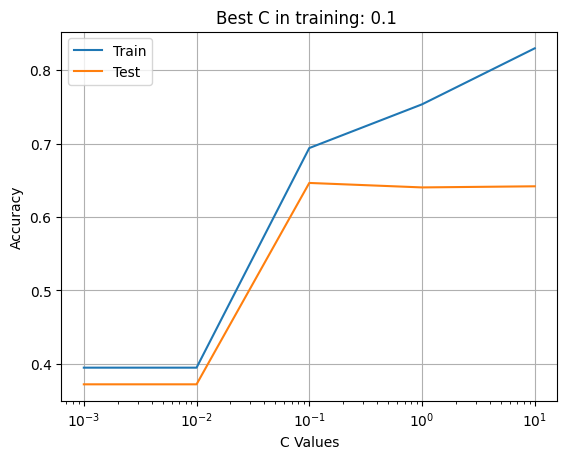

In [42]:
# list to record the accuracy
training_accuracy = []
testing_accuracy = []

# list to record the error
training_error = []
testing_error = []

# C Hyperparameter - Define a list of specific C values
C_param = [0.001, 0.01, 0.1, 1.0, 10.0]


for C_value in C_param:
    # Create the SVC model with the current C_value
    rbf_model = SVC(kernel='rbf', C=C_value,class_weight='balanced')
    rbf_model_train = rbf_model.fit(X_train_trf, y_train)

    # Appending the Accuracy Score - Use scaled data for evaluation
    training_accuracy.append(rbf_model_train.score(X_train_trf, y_train))
    testing_accuracy.append(rbf_model_train.score(X_test_trf, y_test))

    # Appending the Error Score
    training_error.append(1 - rbf_model_train.score(X_train_trf, y_train))
    testing_error.append(1 - rbf_model_train.score(X_test_trf, y_test))

# Find the best C based on testing accuracy
best_C_index = np.argmax(testing_accuracy)
best_C = C_param[best_C_index]

print(f"Best C value based on testing accuracy: {best_C}")
print(f"Corresponding training accuracy: {training_accuracy[best_C_index]:.2f}")
print(f"Corresponding testing accuracy: {testing_accuracy[best_C_index]:.2f}")



def plot_log(X_values, train_values, test_values, Xlabel, ylabel, title):
    plt.semilogx(X_values, train_values, X_values, test_values)
    plt.xlabel(Xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(("Train", "Test"))
    plt.grid()
    plt.show()


plot_log(C_param, training_accuracy, testing_accuracy, "C Values", "Accuracy", title=f"Best C in training: {best_C:1g} ")

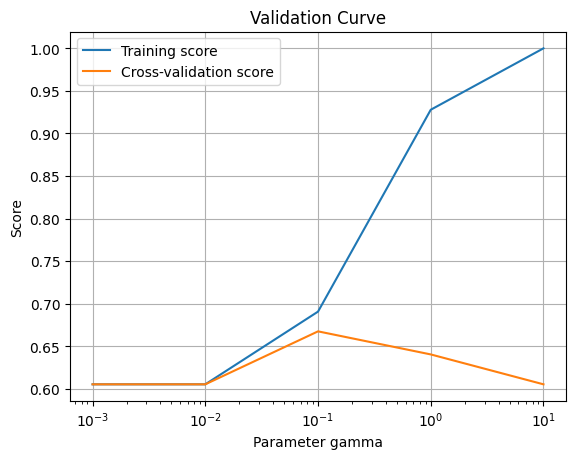

In [43]:
# Example: Validation curve for SVC

# gamma values
gamma_param = [0.001, 0.01, 0.1, 1.0, 10.0]

# compute validation curve
train_scores, test_scores = validation_curve(
     SVC(kernel="rbf"),
     X_train_trf, y_train,
     param_name="gamma",
     param_range = gamma_param,
     scoring="accuracy",
     cv=5
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.semilogx(gamma_param, train_scores_mean, label="Training score")
plt.semilogx(gamma_param, test_scores_mean, label="Cross-validation score")
plt.title("Validation Curve")
plt.xlabel("Parameter gamma")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()


For $C > 0.1$ the training score is high and the validation score is low, the estimator is overfitting. For $ C < 10^{-2}$ the training score and the validation score are both low, the estimator will be underfitting. The best value is $C = 0.1$. From the validation curve for $\gamma$ we also have the best values $\gamma = 0.1$

Next, the KDE plot illustrates the probability distributions of the actual and predicted values. There is a visible gap between the curves  where potability equals 1. This gap indicate that the model’s predicted values differ noticeably from the true values for the potable class  and that the model isn't capturing the underlying distribution well for that class, signaling room for improvement.

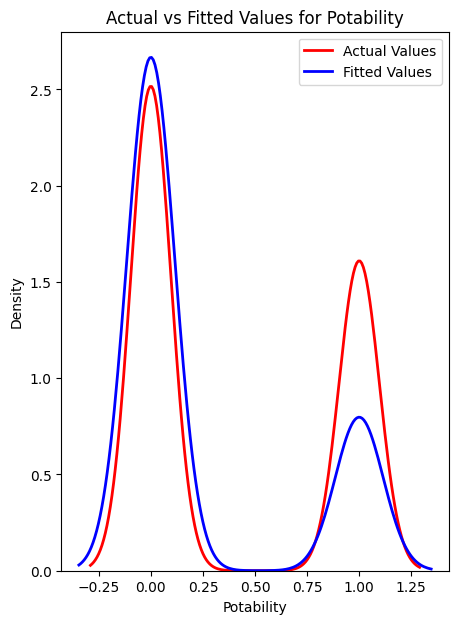

In [44]:
plt.figure(figsize=(5, 7))

# Plot actual values
ax = sns.kdeplot(y, color="r", label="Actual Values", linewidth=2)

# Plot predicted values
sns.kdeplot(y_test_pred_rbf, color="b", label="Fitted Values", ax=ax, linewidth=2)

# Add labels and title
plt.title('Actual vs Fitted Values for Potability')
plt.xlabel('Potability')
plt.ylabel('Density')

# Add legend with location specified
plt.legend(loc='upper right')

# Show and close plot
plt.show()
plt.close()

In [45]:
model = SVC(kernel='rbf', C=0.1,class_weight='balanced', gamma = 0.1, probability=True)
# Train the model with the training data
model.fit(X_train_trf, y_train)
proba_pred = model.predict_proba(X_test_trf)

# Probability
prob_pot_svm = pd.DataFrame(proba_pred, columns=['P(y=0|X)', 'P(y=1|X)'])
prob_pot_svm.head(15)

,P(y=0|X),P(y=1|X)
0,0.749276,0.250724
1,0.702862,0.297138
2,0.689033,0.310967
3,0.545506,0.454494
4,0.655909,0.344091
5,0.401130,0.598870
6,0.573404,0.426596
7,0.453974,0.546026
8,0.457643,0.542357
9,0.688888,0.311112


## 5) Random Forest

With the aim of improving model performance, I have implemented a Random Forest classifier as an alternative to the SVM

Standarization or normalization is not needed for tree bases models. Therefore, I just consider the missing values imputation.

In [46]:
# Create an instance of KNNImputer without scale
imputer_knn = KNNImputer(n_neighbors=10, weights="uniform") # default values for weights = uniform and metric = nan_euclidean

# Apply KNN imputation, fit and transform
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Verify that missing values are gone
print("\nMissing values after KNN imputation:")
print(sum(np.isnan(X_train_imp)))


Missing values after KNN imputation:
[0 0 0 0 0 0 0 0 0]


#### Tuning the hyperparameters
Looking for the best model for different values of the hyperparameters.

In [47]:
param_dist = {'n_estimators': randint(5,25),
              'max_depth': randint(1,30)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 42,criterion='gini')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_imp, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 13}


In [48]:
# Construct the model  with the best hyperparameters
rf_model = RandomForestClassifier(random_state = 42,  **rand_search.best_params_)

# Fit model with the training data.
rf_model.fit(X_train_imp, y_train)

# prediction of the rf model
y_pred =rf_model.predict(X_test_imp)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(y_test, y_pred)

In [49]:
# Evaluation of the classification
rf_classification = classification_report(y_test, y_pred)
print(rf_classification)


              precision    recall  f1-score   support

           0       0.69      0.88      0.77       412
           1       0.62      0.34      0.44       244

    accuracy                           0.68       656
   macro avg       0.66      0.61      0.61       656
weighted avg       0.67      0.68      0.65       656



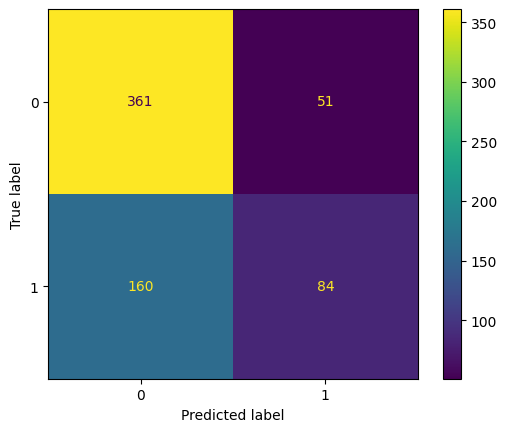

In [50]:
# Generate predictions with the best model
y_pred_set = best_rf.predict(X_test_imp)

# Create the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot();

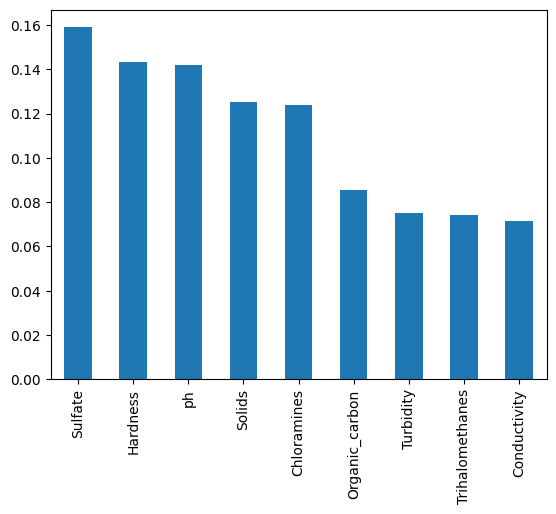

In [51]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [52]:
# Probability
prob_pot_rf = pd.DataFrame(rf_model.predict_proba(X_test_imp), columns=['P(y=0|X)', 'P(y=1|X)'])
prob_pot_rf.head(15)

,P(y=0|X),P(y=1|X)
0,0.644328,0.355672
1,0.693056,0.306944
2,0.713365,0.286635
3,0.523293,0.476707
4,0.561052,0.438948
5,0.153846,0.846154
6,0.445787,0.554213
7,0.672573,0.327427
8,0.499693,0.500307
9,0.697894,0.302106


In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pickle

# Đọc dữ liệu
df = pd.read_csv("water_potability.csv")

# Xử lý thiếu dữ liệu
df = df.dropna()

# Chia features và labels
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Scale dữ liệu
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Lưu mô hình và scaler vào file
with open("model.pkl", "wb") as f:
    pickle.dump((model, scaler), f)

print("✅ Mô hình đã được huấn luyện và lưu thành công.")


✅ Mô hình đã được huấn luyện và lưu thành công.


## 6) Kết luận

* Giữa hai mô hình, SVM đã đạt được độ chính xác của thử nghiệm là 0,65, trong khi Random Forest hoạt động tốt hơn với độ chính xác của thử nghiệm là 0,70.


*  Nước bị ô nhiễm có nguy cơ nghiêm trọng, như bệnh thậm chí đã chết. Do đó, việc giảm dương tính giả trong mô hình là rất quan trọng. So với mô hình SVM, mô hình RF đã giảm số lượng dương tính giả từ 69 xuống còn 18, đây là một sự cải thiện đáng kể.


## 7) Tài liệu tham khảo

1. [CF_Blog](https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/)
2. [Outliers](https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python)
3. [Normalization-Standarization](https://pmc.ncbi.nlm.nih.gov/articles/PMC3489534/#:~:text=We%20suggest%20that%20normalization%20be,imputation%2C%20significance%20analysis%20and%20visualization)
4. [Normalize after or before imputation](https://stats.stackexchange.com/questions/214728/should-data-be-normalized-before-or-after-imputation-of-missing-data)
5. [Medium_SVM](https://medium.com/data-science/svm-support-vector-machine-for-classification-710a009f6873)

In [55]:
!wget -q -O - https://loca.lt/mytunnelpassword

35.194.201.238

In [56]:
!pip install streamlit
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
changed 22 packages in 2s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦

In [74]:
# 1. Import thư viện
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
import pickle

# 2. Đọc dữ liệu
df = pd.read_csv("water_potability.csv")
df.dropna(inplace=True)  # Loại bỏ dữ liệu thiếu

# 3. Chia dữ liệu
X = df.drop("Potability", axis=1)
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Chuẩn hóa dữ liệu với RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Huấn luyện mô hình
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# 6. Dự đoán và đánh giá
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 7. Lưu mô hình và scaler
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


Accuracy: 0.652605459057072


In [75]:
import streamlit as st
import pickle
import numpy as np

# Load mô hình và scaler
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Giao diện web
st.title("🔍 Dự đoán chất lượng nước")

ph = st.number_input("pH", min_value=0.0, max_value=14.0, value=7.0)
hardness = st.number_input("Độ cứng", min_value=0.0, value=150.0)
solids = st.number_input("Chất rắn", min_value=0.0, value=10000.0)
chloramines = st.number_input("Chloramines", min_value=0.0, value=7.0)
sulfate = st.number_input("Sulfate", min_value=0.0, value=300.0)
conductivity = st.number_input("Độ dẫn điện", min_value=0.0, value=400.0)
organic_carbon = st.number_input("Carbon hữu cơ", min_value=0.0, value=10.0)
trihalomethanes = st.number_input("Trihalomethanes", min_value=0.0, value=70.0)
turbidity = st.number_input("Độ đục", min_value=0.0, value=3.0)

# Dự đoán
if st.button("Dự đoán"):
    input_data = np.array([[ph, hardness, solids, chloramines, sulfate, conductivity,
                            organic_carbon, trihalomethanes, turbidity]])
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)

    if prediction[0] == 1:
        st.success("✅ Nước có thể uống được!")
    else:
        st.error("❌ Nước KHÔNG an toàn để uống!")


2025-07-24 13:30:37.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.825 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.826 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.829 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.830 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.831 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:30:37.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501


⠙

⠹⠸⠼⠴⠦⠧⠇⠏
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.194.201.238:8501

⠋⠙⠹⠸⠼⠴⠦your url is: https://violet-bottles-raise.loca.lt
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/